# Настройки/Импорты

In [1]:
!pip install transformers==4.45.2
!pip install evaluate
!pip install seaborn==0.13.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 70.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [2]:
import os # для взаимодействия с системой
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом
import random as random # для работы со случайностью
import pickle # для сохранения и загрузки объектов
from tqdm.auto import tqdm # для отслеживания прогресса

from datasets import Dataset, load_dataset, load_from_disk # для работы с HuggingFace датасетами

import torch # для работы с моделями torch
from transformers import MarianMTModel, MarianTokenizer # для работы с Marian моделью
from transformers import DataCollatorForSeq2Seq # для сборщика данных (чтобы)
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer # для обучения модели
from transformers import EarlyStoppingCallback # callback для ранней остановки обучения

import time # для отслеживания времени выполнения
import matplotlib.pyplot as plt # для построения графиков
import seaborn as sns # для построения красивых графиков
import evaluate # для подсчёта метрик

In [3]:
DATA_DIR = "/kaggle/working/data/" # путь до папки с данными
RESULTS_DIR = "/kaggle/working/results/" # путь до папки с результатами вычислений
EMBEDDING_DIR = "/kaggle/working/embeddings/" # путь до папки с эмбеддингами
MODELS_DIR = "/kaggle/working/models/" # путь до папки с моделями
MODEL_NAME = "Helsinki-NLP/opus-mt-ine-ine" # название модели для перевода
DATASET_NAME_HF = "aiana94/polynews-parallel"
DATASET_NAME_LOC = "polynews-parallel"

MAX_SEQUENCE_LEN = 256 # оптимальное число токенов в документе (если не достаёт — padding, если перебор — truncation), определялось по гистограмме распределения числа токенов в текстах

RANDOM_STATE = 42 # число для задания случайности
TEST_SIZE = 0.2 # размер тестовой выборки
TEST_MAX_SAMPLES = 10000 # максимальное число тестовых примеров для прогона на CPU
TRAIN_MAX_SAMPLES = 40000 # максимальное число обучающих примеров

EPOCHS = 10 # число эпох обучения
EPOCHS_PATIENCE = 2 # число эпох без изменения наблюдаемой метрики, после которого обучение прекратится
LEARNING_RATE = 0.00001 # learning rate
BATCH_SIZE = 24 # размер батча (число сэмплов, передаваемых в модель одновременно => чем больше значение - тем быстрее обучение, но хуже качество из-за аккумуляции градиентов)

In [4]:
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"Девайс: {DEVICE}.")

Девайс: cpu.


# Работа с моделью

In [5]:
model = MarianMTModel.from_pretrained(MODEL_NAME)
model.save_pretrained(MODELS_DIR + MODEL_NAME, from_pt=True) # сохранение модели
model

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/266M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[42740]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(42741, 512, padding_idx=42740)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(42741, 512, padding_idx=42740)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [6]:
params_all = sum(p.numel() for p in model.parameters())
params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Число обучаемых параметров: {params_trainable} из {params_all}, то есть ~{params_trainable / params_all * 100:.2f}%.") # считаем число параметров

Число обучаемых параметров: 66021888 из 66546176, то есть ~99.21%.


In [7]:
tokenizer = MarianTokenizer.from_pretrained(MODEL_NAME)
tokenizer.save_pretrained(MODELS_DIR + MODEL_NAME) # сохранение токенизатора
tokenizer

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/773k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


MarianTokenizer(name_or_path='Helsinki-NLP/opus-mt-ine-ine', vocab_size=42741, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	42740: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [8]:
vocab_len = tokenizer.vocab_size # размер словаря
print(f"Размер словаря токенизатора: {vocab_len}, с учётом особых токенов: {len(tokenizer.get_vocab())}.")

Размер словаря токенизатора: 42741, с учётом особых токенов: 42741.


In [9]:
print(tokenizer.supported_language_codes)

['>>eng<<', '>>fra<<', '>>deu<<', '>>spa<<', '>>rus<<', '>>ita<<', '>>pol<<', '>>por<<', '>>nld<<', '>>nob<<', '>>dan<<', '>>ces<<', '>>swe<<', '>>ukr<<', '>>ron<<', '>>bul<<', '>>ell<<', '>>afr<<', '>>lat_Latn<<', '>>mkd<<', '>>bel<<', '>>nds<<', '>>ind<<', '>>pes<<', '>>yid<<', '>>fry<<', '>>lit<<', '>>lav<<', '>>isl<<', '>>srp_Cyrl<<', '>>cat<<', '>>slv<<', '>>kur_Latn<<', '>>cym<<', '>>hrv<<', '>>hin<<', '>>srp_Latn<<', '>>glg<<', '>>nno<<', '>>gle<<', '>>oci<<', '>>urd<<', '>>ast<<', '>>gla<<', '>>bre<<', '>>bos_Latn<<', '>>mar<<', '>>asm<<', '>>hye<<', '>>pap<<', '>>ben<<', '>>ltz<<', '>>hat<<', '>>wln<<', '>>ang_Latn<<', '>>oss<<', '>>sqi<<', '>>tgk_Cyrl<<', '>>glv<<', '>>csb_Latn<<', '>>hsb<<', '>>mai<<', '>>guj<<', '>>ori<<', '>>rom<<', '>>zlm_Latn<<', '>>mfe<<', '>>pus<<', '>>pan_Guru<<', '>>sin<<', '>>snd_Arab<<', '>>arg<<', '>>kur_Arab<<', '>>bul_Latn<<', '>>bel_Latn<<', '>>cor<<', '>>fao<<', '>>san_Deva<<', '>>mwl<<', '>>rus_Latn<<', '>>sco<<', '>>ltg<<', '>>min<<', '>>hye

In [10]:
word2id = {} # словарь соответствия слова его id_шнику
id2word = {} # словарь соответствия id_шника слову
for word, id in tokenizer.get_vocab().items(): # идём по словам в словаре
    word2id[word] = id # заполняем словарь соответствия слова его id_шнику
    id2word[id] = word # заполняем словарь соответствия id_шника слову

In [11]:
prefix = ">>eng<< "
src_text = prefix + "Цель разработки — предоставить пользователям личного синхронного переводчика."

tokens_encoded = tokenizer(src_text, max_length=tokenizer.max_len_single_sentence, return_tensors="pt", truncation=True, padding=True) # токенизируем данные (max_length — максимальное число токенов в документе, return_tensors — тип возвращаемых данных, np для numpy.array, pt для torch.tensor; truncation и padding — обрезание лишних токенов и автозаполнение недостающих до max_length)
print(f"Пример токенизации документа: {tokens_encoded}.") # пример токенизации первого документа

Пример токенизации документа: {'input_ids': tensor([[   42,  3861,   566,   887,     1,   519,   171,  1264,   220, 21467,
         25105,  7081,   956, 18718,  7350,   292,  7187,  1901,  1587,  2831,
          1047,   249,     2,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}.


In [12]:
for token in tokens_encoded['input_ids'][0].numpy(): # идём по токенам
    print(f"{token} — {id2word[token]}") # выводим токен (id) и соответствующее ему слово

42 — >>eng<<
3861 — ▁Це
566 — ль
887 — ▁раз
1 — <unk>
519 — ки
171 — ▁—
1264 — ▁пред
220 — о
21467 — ставить
25105 — ▁пользовател
7081 — ям
956 — ▁ли
18718 — чного
7350 — ▁син
292 — х
7187 — рон
1901 — ного
1587 — ▁пере
2831 — вод
1047 — чи
249 — ка
2 — .
0 — </s>


In [13]:
tokens_generated = model.generate(**tokens_encoded)

# result = tokenizer.batch_decode(tokens_generated, skip_special_tokens=True)
result = tokenizer.batch_decode(tokens_generated, skip_special_tokens=False)
print(result)

['<pad> The goal of the time is to provide the users of a personal synchronous translation.</s>']


# Работа с датасетом

In [14]:
dataset = load_dataset(DATASET_NAME_HF, name="eng_Latn-rus_Cyrl") # скачивание датасета, name — название subset_а с HuggingFace
dataset.save_to_disk(DATA_DIR + DATASET_NAME_LOC) # локальное сохранение датасета (в формате arrow)
dataset

README.md:   0%|          | 0.00/107k [00:00<?, ?B/s]

train.parquet.gzip:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/176441 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/176441 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['src', 'tgt', 'provenance'],
        num_rows: 176441
    })
})

In [15]:
dataset["train"][0]

{'src': 'Parliament Does Not Support Amendment Freeing Tymoshenko',
 'tgt': 'Парламент не поддерживает поправку, дающую свободу Тимошенко',
 'provenance': 'wmtnews'}

In [16]:
def preprocess_function(data: Dataset, random_state=RANDOM_STATE):
    random.seed(random_state) # Set the random number generator to a fixed sequence.
    samples_count = len(data["src"]) # общее число сэмплов в датасете
    
    reflected_idx = set(random.sample(range(0, samples_count), int(samples_count/2))) # индексы отражаемых сэмплов (set — для сортировки и удобного вычитания)
    regular_idx = set(range(0, samples_count)) - reflected_idx

    data["new_src"] = [">>rus<< " + sample if idx in regular_idx else ">>eng<< " + data["tgt"][idx] for idx, sample in enumerate(data["src"])]
    data["new_tgt"] = [sample if idx in regular_idx else data["src"][idx] for idx, sample in enumerate(data["tgt"])]

    return data

In [17]:
dataset = dataset.map(preprocess_function, batched=True)
dataset = dataset.remove_columns(["provenance", "src", "tgt"]) # удаление ненужной колонки
dataset = dataset.rename_column("new_src", "src") # переименовываем колонку
dataset = dataset.rename_column("new_tgt", "tgt") # переименовываем колонку
dataset = dataset["train"].train_test_split(test_size=TEST_SIZE, shuffle=True, seed=RANDOM_STATE) # разбиение датасета на тестовую и обучающую выборки ()
dataset

Map:   0%|          | 0/176441 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['src', 'tgt'],
        num_rows: 141152
    })
    test: Dataset({
        features: ['src', 'tgt'],
        num_rows: 35289
    })
})

In [18]:
dataset["train"][0]

{'src': ">>eng<< Один из авторов блога Jumbie's Watch также был потрясен тем, как министр Сент-Роуз Гривз была избавлена от ответственности, хотя помнится она публично признала её. ",
 'tgt': "Diaspora blogger Jumbie's Watch was also confused as to how Minister St. Rose-Greaves was spared, since he remembers her publicly accepting responsibility. "}

In [19]:
dataset.save_to_disk(DATA_DIR + DATASET_NAME_LOC + "_t5_processed") # локальное сохранение датасета (в формате arrow)
# dataset = load_from_disk(DATA_DIR + DATASET_NAME_LOC + "_t5_processed") # загрузка локально сохранённого датасета

Saving the dataset (0/1 shards):   0%|          | 0/141152 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35289 [00:00<?, ? examples/s]

# Baseline (замер основных метрик)

In [20]:
def translate(model, tokenizer, texts) -> tuple:
    tokens_count = [] # список под количество токенов в тексте
    latency = [] # список под величину задержки между запуском модели и выводом ответа
    translations = [] # список под переводы

    if isinstance(texts, Dataset) or isinstance(texts, dict): # если пришёл объект типа Dataset или словарь (полученный с помощью среза объекта Dataset)
        texts = texts["src"] # берём из него только текста, что нужно переводить
        
    model.eval() # перевод модели в режим оценивания (dropout перестаёт работать, а BatchNorm собирать статистику)

    with torch.no_grad(): # отключаем подсчёт градиентов
        #================================ Быстрый перевод батчами ==========================================
        # tokens_encoded = tokenizer(texts, max_length=tokenizer.max_len_single_sentence, return_tensors="pt", truncation=True, padding=True) # токенизируем данные (max_length — максимальное число токенов в документе, return_tensors — тип возвращаемых данных, np для numpy.array, pt для torch.tensor; truncation и padding — обрезание лишних токенов и автозаполнение недостающих до max_length)
        # tokens_generated = model.generate(**tokens_encoded)
        # translations = tokenizer.batch_decode(tokens_generated, skip_special_tokens=True) # декодирование последовательности токенов (аналог .decode, но для работы с несколькими последовательностями сразу), skip_special_tokens — выводить ли специальные токены
        #-------------------------------- Перевод для учёта времени работы ---------------------------------
        for idx, text in tqdm(enumerate(texts)):
            # text = "translate to ru: " + text # добавляем промпт для того, чтобы модель знала, что нужно делать
            time_start = time.time() # замеряем время начала работы  с моделью

            tokens_encoded = tokenizer(text, max_length=tokenizer.max_len_single_sentence, return_tensors="pt", truncation=True, padding=True) # токенизируем данные (max_length — максимальное число токенов в документе, return_tensors — тип возвращаемых данных, np для numpy.array, pt для torch.tensor; truncation и padding — обрезание лишних токенов и автозаполнение недостающих до max_length)
            tokens_count.append(tokens_encoded["input_ids"].shape[1]) # запоминаем количество токенов

            tokens_generated = model.generate(**tokens_encoded) # генерируем новую последовательность токенов (переводим текст)
            translations.append(tokenizer.decode(tokens_generated[0], skip_special_tokens=True)) # декодирование последовательности токенов, skip_special_tokens — выводить ли специальные токены

            latency.append(time.time()  - time_start)
        #---------------------------------------------------------------------------------------------------
    
    return tokens_count, latency, translations

In [21]:
tokens_count, latency, translations = translate(model, tokenizer, dataset["test"][:TEST_MAX_SAMPLES])

0it [00:00, ?it/s]

In [22]:
translations[:5]

['The Clinton Fund suggests to introduce a device based by the miniprint in 682 blood transmission centres throughout the country.',
 'Тем не менее, как отмечалось в выборе двух популярных телевизорных серий, стороны укрепляют власти на случайном и избирательном сенсоре и запрещают вызовы их идеологии.',
 'Неудивительно, что слова становятся грязными, чтобы помочь прекратить плакать, помогать ребенку спать или выразить утешение или надежду.',
 'Participants are now addressing the United Nations Secretary-General Pan Gi Mun to support human rights obligations and to need immediate release of Bassel.',
 'Этот рассказ Джойс Хаксел оригинално появился на PRI.org 14 июня 2017 года.']

In [23]:
dataset["test"]["src"][:5]

['>>eng<< Фонд Клинтона предполагает внедрить устройство, оснащенное минипринтером, в 682 центрах по забору крови по всей стране. ',
 '>>rus<< Yet, as the takedown of the two popular online TV series indicated, the party guidelines empower authorities to arbitrarily and selectively censor and ban content that they find challenges their ideology. ',
 '>>rus<< It is not surprising that words become spells to help stop the crying, help the child go to sleep, or express encouragement or hope. ',
 '>>eng<< Сейчас сторонники обращаются к генеральному секретарю ООН Пан Ги Муну с просьбой оказать поддержку международным обязательствам в области прав человека и потребовать немедленного освобождения Басселя. ',
 '>>rus<< This story by Joyce Hackel originally appeared on PRI.org on June 14, 2017. ']

In [24]:
dataset["test"]["tgt"][:5]

['The Clinton Foundation and the telecommunications operator MTN have partnered to fight against the late diagnosis of HIV testing in newborns. This new mobile device will include a pocket-size printer and will be distributed in 682 testing centers across the country. ',
 'Однако запрещение двух популярных сериалов показывает, что партийные руководства расширяют полномочия властей относительно избирательной цензуры и регулирования контента, идущего против их идеологии. ',
 'Не удивительно, что слова становятся заклинаниями, для того чтобы помочь остановить плач, помочь ребенку заснуть, выразить поддержку или надежду. ',
 "Supporters are now turning to the United Nations’ Secretary-General Ban Ki-moon and asking for his support to uphold international commitments to human rights and demand Bassel's immediate and safe release. ",
 'Эта статья Джойс Хакел изначально была опубликована на PRI.org 14 июня 2017г. ']

In [25]:
if not os.path.exists(RESULTS_DIR + MODEL_NAME):
    os.makedirs(RESULTS_DIR + MODEL_NAME)

with open(RESULTS_DIR + MODEL_NAME + "/tokens_count.pkl", "wb") as f: # открываем файл для записи по битам (wb)
    pickle.dump(tokens_count, f) # сохраняем объект в файл f
with open(RESULTS_DIR + MODEL_NAME + "/latency.pkl", "wb") as f: # открываем файл для записи по битам (wb)
    pickle.dump(latency, f) # сохраняем объект в файл f
with open(RESULTS_DIR + MODEL_NAME + "/translations.pkl", "wb") as f: # открываем файл для записи по битам (wb)
    pickle.dump(translations, f) # сохраняем объект в файл f

In [26]:
# with open(RESULTS_DIR + MODEL_NAME + "/tokens_count.pkl", "rb") as f: # открываем файл для чтения по битам (rb)
#     tokens_count = pickle.load(f) # загружаем объект из файла
# with open(RESULTS_DIR + MODEL_NAME + "/latency.pkl", "rb") as f: # открываем файл для чтения по битам (rb)
#     latency = pickle.load(f) # загружаем объект из файла
# with open(RESULTS_DIR + MODEL_NAME + "/translations.pkl", "rb") as f: # открываем файл для чтения по битам (rb)
#     translations = pickle.load(f) # загружаем объект из файла

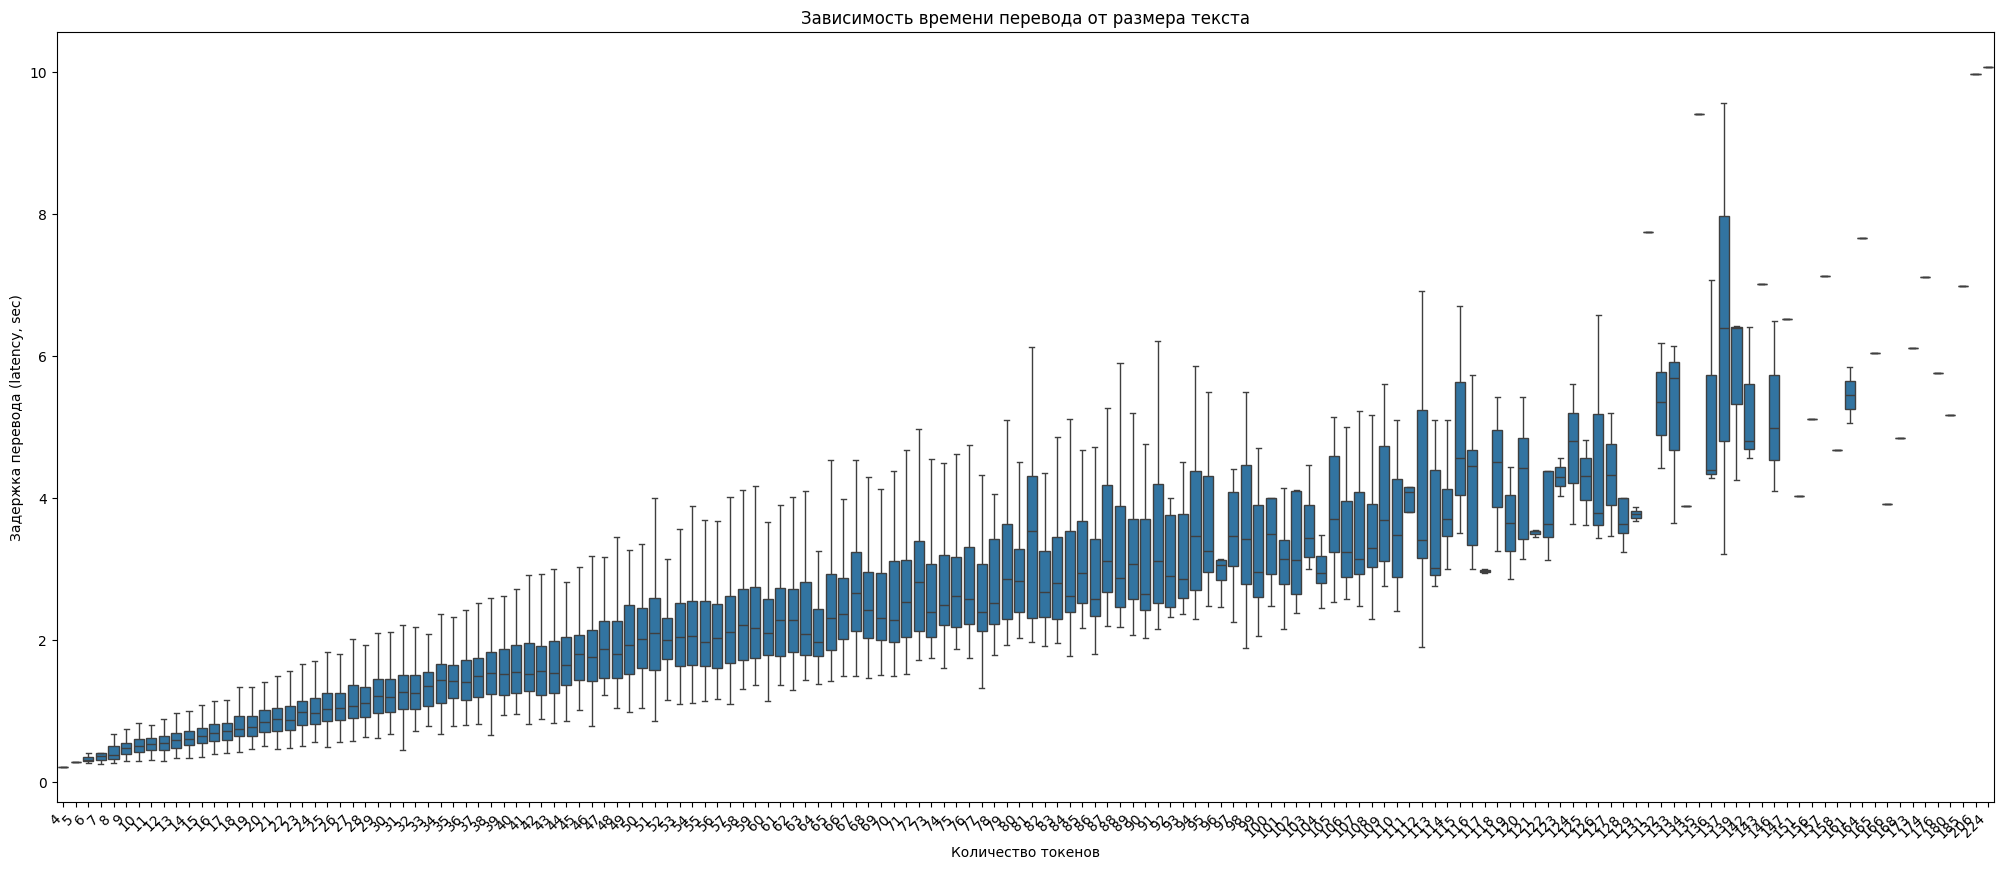

In [27]:
plt.figure(figsize=(25,10)) # задание размера фигуры
sns.boxplot(x=tokens_count, y=latency, showfliers=False) # строим "ящики с усами", showfliers — отображать ли выбросы
plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title("Зависимость времени перевода от размера текста") # название фигуры
plt.xlabel("Количество токенов") # подпись по оси x
plt.ylabel("Задержка перевода (latency, sec)") # подпись по оси y
plt.show() # показ фигуры

In [28]:
results = pd.DataFrame({"Tokens count": tokens_count, "Latency": latency}) # собираем данные в DataFrame
results.sort_values(by=["Tokens count"], inplace=True)
results.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True - перезаписываем существующий датасет)
results

,Tokens count,Latency
0,4,0.208276
1,5,0.285272
2,6,0.307320
3,6,0.403404
4,6,0.269095
...,...,...
9995,176,5.756909
9996,180,5.169370
9997,185,6.989686
9998,206,9.966472


In [29]:
stats = results.groupby(by="Tokens count", as_index=True).agg(mean=("Latency", "mean"),
                                                              std=("Latency", "std")
                                                             )
stats

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,mean,std
Tokens count,,
4,0.208276,NaN
5,0.285272,NaN
6,0.326607,0.069200
7,0.346001,0.071489
8,0.412817,0.118642
...,...,...
176,5.756909,NaN
180,5.169370,NaN
185,6.989686,NaN


Удаляем записи-выбросы (оставляем только те записи, у которых отличие от среднего значения не более трёх стандартных отклонений).

In [30]:
outlier_indexes = []

for index in results.index:
    tokens_count_, latency_ = results.loc[index]
    if np.abs(latency_ - stats.loc[tokens_count_]["mean"]) > 3 * stats.loc[tokens_count_]["std"]:
        outlier_indexes.append(index)

results.drop(outlier_indexes, inplace=True)
results

,Tokens count,Latency
0,4,0.208276
1,5,0.285272
2,6,0.307320
3,6,0.403404
4,6,0.269095
...,...,...
9995,176,5.756909
9996,180,5.169370
9997,185,6.989686
9998,206,9.966472


Пересчитываем значения статистик без выбросов.

In [31]:
stats = results.groupby(by="Tokens count", as_index=True).agg(mean=("Latency", "mean"),
                                                              std=("Latency", "std")
                                                             )
stats

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,mean,std
Tokens count,,
4,0.208276,NaN
5,0.285272,NaN
6,0.326607,0.069200
7,0.346001,0.071489
8,0.412817,0.118642
...,...,...
176,5.756909,NaN
180,5.169370,NaN
185,6.989686,NaN


Строим $y=ax+b$ линейную аппроксимацию графика, чтобы найти коэффициенты увеличения времени от размера текста.

In [32]:
a, b = np.polyfit(stats.index[:75], stats["mean"][:75], deg=1) # считаем линейную аппроксимацию (deg=1), [:75] — так как после идёт большой разброс по времени из-за малой представленности в датасете
print(f"Затрачиваемое время увеличивается, в среднем, на {a:.5f} секунд за каждый новый токен, при этом модель работает не менее {b:.5f} секунд.")

Затрачиваемое время увеличивается, в среднем, на 0.03513 секунд за каждый новый токен, при этом модель работает не менее 0.16822 секунд.


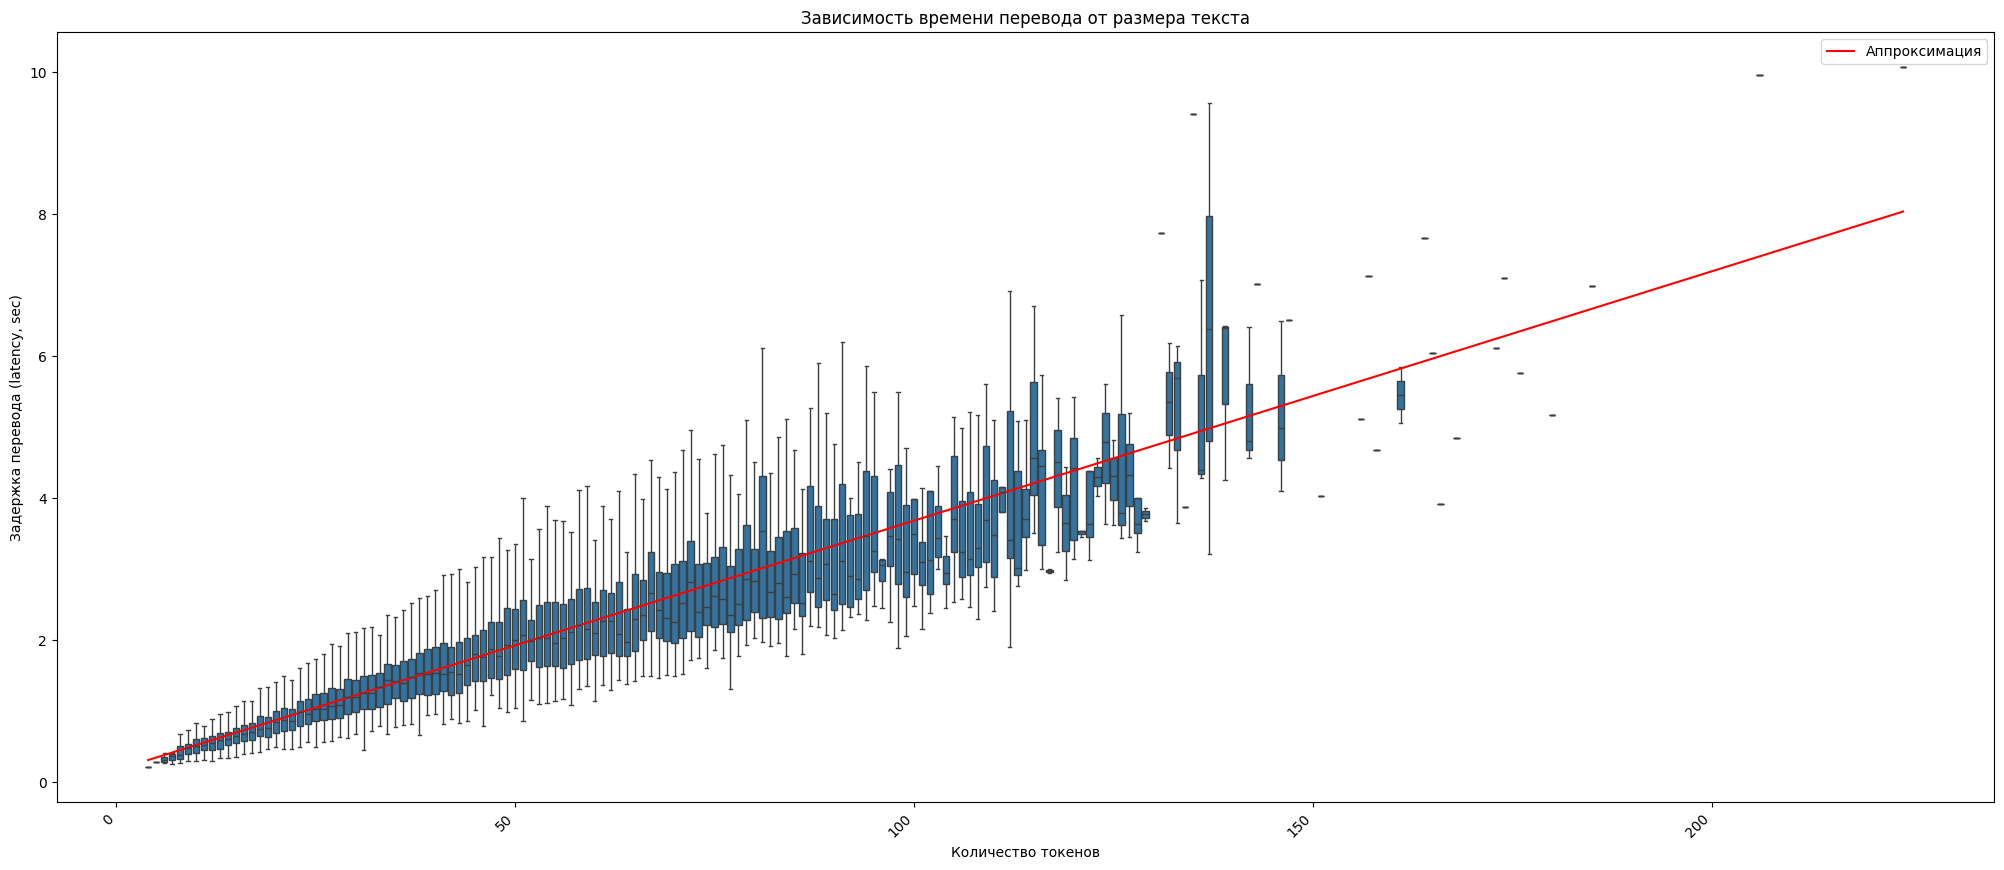

In [33]:
plt.figure(figsize=(25,10)) # задание размера фигуры
sns.boxplot(x=results["Tokens count"], y=results["Latency"], native_scale=True, showfliers=False) # строим "ящики с усами", showfliers — отображать ли выбросы, native_scale — воспринимать ли ось X как непрерывную (а не категориальную)

x = np.linspace(stats.index[0], stats.index[-1])
# x = stats.index.to_numpy() # рассмотренные значения по оси x для линейного графика
y = a * x + b
sns.lineplot(x=x, y=y, color="red", label="Аппроксимация")
# sns.pointplot(x=x, y=y, color="red", label="Аппроксимация") # pointplot в данном случае идёт как аналог линейного графика, у которого ось X воспринимается "категориально", то есть так же, как в boxplot

plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title("Зависимость времени перевода от размера текста") # название фигуры
plt.xlabel("Количество токенов") # подпись по оси x
plt.ylabel("Задержка перевода (latency, sec)") # подпись по оси y
plt.legend() # отображение подписей графиков
plt.show() # показ фигуры

In [34]:
metric_BLEU = evaluate.load("bleu") # загружаем метрику

In [35]:
metric_BLEU.compute(predictions=translations, references=dataset["test"]["tgt"][:TEST_MAX_SAMPLES]) # считаем значение метрики
# metric_BLEU.compute(predictions=translations, references=[[ref] for ref in dataset["test"]["tgt"][:TEST_MAX_SAMPLES]]) # считаем значение метрики

{'bleu': 0.14473224274182503,
 'precisions': [0.45996319603789443,
  0.19679653473594022,
  0.0996076667416348,
  0.05247985186120405],
 'brevity_penalty': 0.9813158590306434,
 'length_ratio': 0.9814882534472609,
 'translation_length': 220085,
 'reference_length': 224236}